In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from src.preprocessing import train_test_split_data, build_preprocessor
from src.feature_selection import make_selector
from src.hyperparameter_tuning import tune_random_forest

# Load
df = pd.read_csv("data/credit_clean.csv")
X_train, X_test, y_train, y_test = train_test_split_data(df)

# Fit base preprocessor+selector and transform training data once
pre = build_preprocessor(X_train)
selector = make_selector()

base_pipe = Pipeline([("pre", pre), ("sel", selector)])
Xtr = base_pipe.fit_transform(X_train, y_train)
Xte = base_pipe.transform(X_test)

# Tune RF on transformed training matrix
study = tune_random_forest(Xtr, y_train.values, n_trials=30)
study.best_params


C:\Users\tabed\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-21 20:58:55,999] A new study created in memory with name: no-name-d3bd416a-ad24-42b0-a39f-aa711940f817
[I 2025-08-21 20:59:23,383] Trial 0 finished with value: 0.47605022651416384 and parameters: {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 0.6269155499573901, 'bootstrap': False}. Best is trial 0 with value: 0.47605022651416384.
[I 2025-08-21 20:59:47,047] Trial 1 finished with value: 0.468836874897942 and parameters: {'n_estimators': 900, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 0.4471198193024762, 'bootstrap': True}. Best is trial 0 with value: 0.47605022651416384.
[I 2025-08-21 20:59:55,474] Trial 2 finished with value: 0.471936073363791

{'n_estimators': 500,
 'max_depth': 16,
 'min_samples_split': 13,
 'min_samples_leaf': 8,
 'max_features': 0.6381668770474211,
 'bootstrap': False}

In [2]:
best_rf = RandomForestClassifier(**study.best_params)
best_rf.fit(Xtr, y_train)
y_pred = best_rf.predict(Xte)
print("Tuned RF Test F1:", f1_score(y_test, y_pred))


Tuned RF Test F1: 0.46308724832214765


              precision    recall  f1-score   support

           0     0.8390    0.9409    0.8870      4673
           1     0.6364    0.3640    0.4631      1327

    accuracy                         0.8133      6000
   macro avg     0.7377    0.6525    0.6751      6000
weighted avg     0.7942    0.8133    0.7933      6000



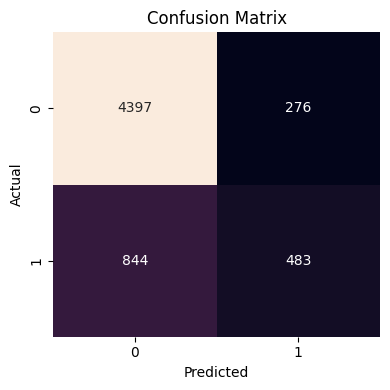

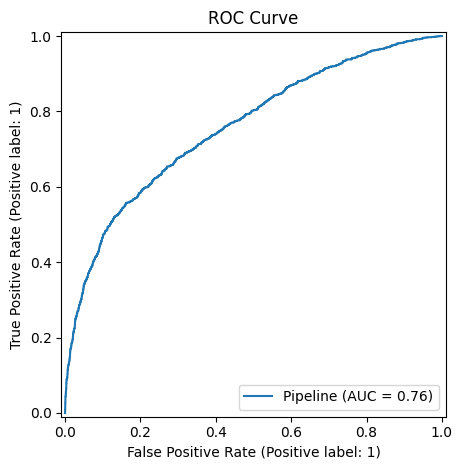

ROC AUC: 0.7579353631009869


In [4]:
from src.evaluation import print_report, plot_confusion, plot_roc

print_report(y_test, y_pred)
plot_confusion(y_test, y_pred)

# For ROC, wrap the full pipeline so predict_proba works properly
final_pipe = Pipeline([("pre", pre), ("sel", selector), ("clf", best_rf)])
final_pipe.fit(X_train, y_train)
plot_roc(final_pipe, X_test, y_test)


In [5]:
from joblib import dump
import os, json
os.makedirs("results", exist_ok=True)

# 1) Save the full pipeline (preprocessor + selector + tuned RF)
dump(final_pipe, "results/final_pipeline.joblib")

# 2) Save test metrics
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

y_proba = final_pipe.predict_proba(X_test)[:, 1]
metrics = {
    "f1": float(f1_score(y_test, y_pred)),
    "precision": float(precision_score(y_test, y_pred)),
    "recall": float(recall_score(y_test, y_pred)),
    "roc_auc": float(roc_auc_score(y_test, y_proba)),
    "n_test": int(len(y_test))
}
with open("results/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

metrics


{'f1': 0.46308724832214765,
 'precision': 0.6363636363636364,
 'recall': 0.36397889977392617,
 'roc_auc': 0.7579353631009869,
 'n_test': 6000}

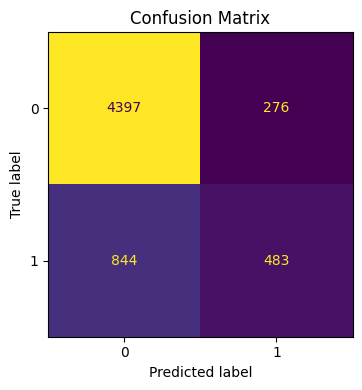

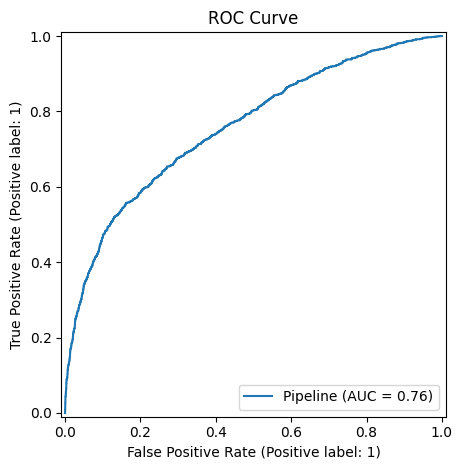

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

# Confusion matrix (save)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
fig_cm, ax_cm = plt.subplots(figsize=(4,4))
disp.plot(ax=ax_cm, colorbar=False)
ax_cm.set_title("Confusion Matrix")
fig_cm.tight_layout()
fig_cm.savefig("results/confusion_matrix.png", dpi=150)

# ROC curve (save)
fig_roc, ax_roc = plt.subplots()
RocCurveDisplay.from_estimator(final_pipe, X_test, y_test, ax=ax_roc)
ax_roc.set_title("ROC Curve")
fig_roc.tight_layout()
fig_roc.savefig("results/roc_curve.png", dpi=150)
